# Modifications de résultats des sondages

## Import préliminaires des librairies

In [62]:
#%pylab inline
# Command OS
import os

# Regex
import re

# Calcul and data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import norm
# Dealing with specific representation of number
# Aka commat in french in numbers
import locale
from locale import atof

### Dark theme pour matplotlib ###
from ing_theme_matplotlib import mpl_style
mpl_style(dark=True)

# Perso
from importlib.machinery import SourceFileLoader
tools = SourceFileLoader('methods', '../methods.py').load_module()
from methods import *


## Import du dataframe

In [63]:



filenames=[f.rstrip('.p') for f in os.listdir('data')]
sum_in_margin=0
total_lines=0
df=pd.read_pickle("data/2020-03-20.p")
data_f=pd.DataFrame(columns=df.columns)
for fn in filenames:
    df=pd.read_pickle("data/{}.p".format(fn))
    df.Base=df.Base.astype('float')
    df['Date']=fn
    data_f=pd.concat([data_f,df])
    in_margin,nb_lines=extract_in_margin(df['ST Favorable'],df['ST Défavorable'],df['Evolution ST Favorable'],df['Evolution ST Défavorable'],df.Base)
    sum_in_margin+=in_margin
    total_lines+=nb_lines
data_f.Date=data_f.Date.astype('datetime64')


data_f.Groupe=data_f.Groupe.str.replace(' ','')
data_f.Categorie=data_f.Categorie.str.replace(' ','')



C:\Users\Romain\AppData\Local\pypoetry\Cache\virtualenvs\mesure-instituts-sondage-z_i9feTs-py3.9\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Romain\AppData\Local\pypoetry\Cache\virtualenvs\mesure-instituts-sondage-z_i9feTs-py3.9\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Romain\AppData\Local\pypoetry\Cache\virtualenvs\mesure-instituts-sondage-z_i9feTs-py3.9\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Romain\AppData\Local\pypoetry\Cache\virtualenvs\mesure-instituts-sondage-z_i9feTs-py3.9\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users

In [64]:
Nom ='Edouard PHILIPPE'
d_margin_err=True

data_f['Inexploitable Favorable']=error_in_margin(data_f['ST Favorable'],data_f["Base"],data_f['Evolution ST Favorable'],double_margin=d_margin_err)
data_f['Inexploitable Défavorable']=error_in_margin(data_f['ST Défavorable'],data_f["Base"],data_f['Evolution ST Défavorable'],double_margin=d_margin_err)
data_f['Erreur Th Favorable']=error_p(data_f['ST Favorable']/100,data_f["Base"])*100
data_f['Erreur Th Défavorable']=error_p(data_f['ST Défavorable']/100,data_f["Base"],)*100
data_f['Inexploitable Favorable'].value_counts()
data_f['Inexploitable Défavorable'].value_counts()
df_inex=pd.DataFrame()
df_inex['Résultats']=pd.concat([data_f['ST Favorable'],data_f['ST Défavorable']])
df_inex['Categorie']=pd.concat([data_f['Categorie'],data_f['Categorie']])
df_inex['Inexploitable']=pd.concat([data_f['Inexploitable Favorable'],data_f['Inexploitable Défavorable']])
df_inex['Nom']=pd.concat([data_f['Nom'],data_f['Nom']])
groupe=df_inex[df_inex.Categorie=='ENSEMBLE']

data_f[data_f.Nom==Nom]


C:\Users\Romain\AppData\Local\pypoetry\Cache\virtualenvs\mesure-instituts-sondage-z_i9feTs-py3.9\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
69,Edouard PHILIPPE,ENSEMBLE,ENSEMBLE,971.0,1.8,19.9,21.7,32.9,39.7,72.6,5.7,-5.0,7.0,2018-12-08,False,False,2.592729,2.805369
70,Edouard PHILIPPE,Sexe,Homme,462.0,1.5,20.7,22.2,34.9,39.4,74.3,3.5,-9.6,9.3,2018-12-08,False,False,3.789670,3.984704
71,Edouard PHILIPPE,Sexe,Femme,509.0,2.1,19.2,21.3,31.2,39.9,71.1,7.6,-0.9,4.9,2018-12-08,True,False,3.556922,3.938047
72,Edouard PHILIPPE,Age,18à24ans,103.0,2.0,24.7,26.7,33.2,27.9,61.1,12.2,4.2,1.1,2018-12-08,True,True,8.543682,9.415272
73,Edouard PHILIPPE,Age,25à34ans,154.0,1.9,11.1,13.0,33.8,43.6,77.4,9.6,-10.5,15.4,2018-12-08,False,False,5.311620,6.605724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,Edouard PHILIPPE,VotePrésidentielle20171ertour,STNonexpr.,229.0,9.5,32.5,42.0,18.6,18.2,36.8,21.3,-0.0,2.0,2021-04-10,False,True,6.392592,6.246270
2376,Edouard PHILIPPE,VotePrésidentielle20172ndtour,EmmanuelMacron,418.0,26.3,48.1,74.4,14.2,6.4,20.5,5.1,7.1,-3.0,2021-04-10,False,True,4.183833,3.870156
2377,Edouard PHILIPPE,VotePrésidentielle20172ndtour,MarineLePen,215.0,5.7,32.6,38.2,30.6,25.8,56.3,5.4,-7.5,10.9,2021-04-10,True,False,6.494755,6.630278
2378,Edouard PHILIPPE,VotePrésidentielle20172ndtour,STExpr.,633.0,19.3,42.8,62.1,19.7,13.0,32.7,5.2,2.2,1.7,2021-04-10,True,True,3.779372,3.654564


## Inexploitable global

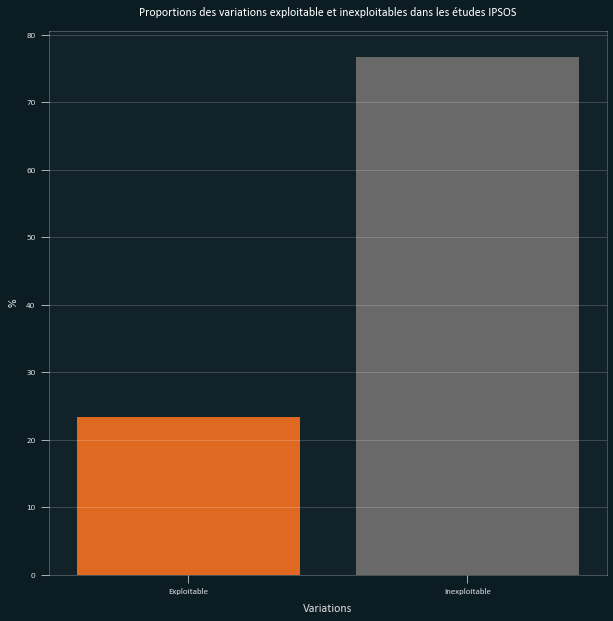

In [65]:
fig = plt.figure(figsize=(10,10))
ax=sns.barplot(x='Inexploitable', y='Inexploitable', data=df_inex, estimator=lambda x: len(x) / len(df_inex) * 100)
ax.set(ylabel="%")
ax.set(xlabel="Variations")
ax.set(title='Proportions des variations exploitable et inexploitables dans les études IPSOS')
ax.set(xticklabels=['Exploitable', 'Inexploitable'])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png',dpi=200)

In [66]:
print(df_inex.Inexploitable.value_counts())
df_inex.Inexploitable.value_counts()/len(df_inex)

True     64367
False    19561
Name: Inexploitable, dtype: int64


True     0.766931
False    0.233069
Name: Inexploitable, dtype: float64

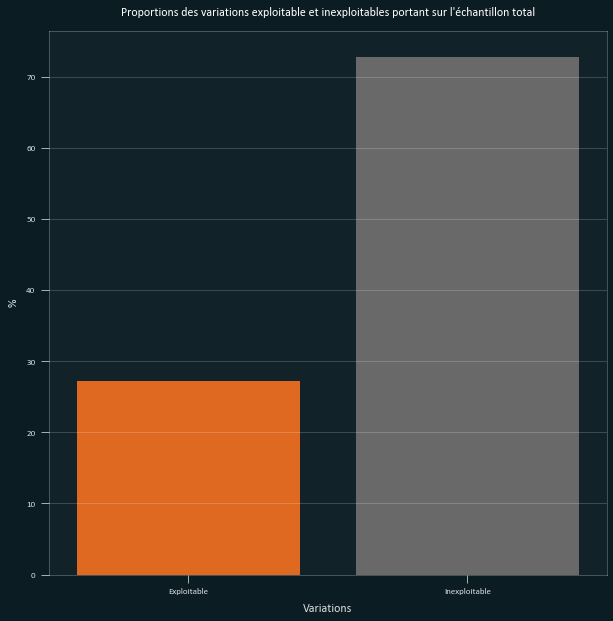

In [67]:
df_inex_ens=df_inex[df_inex.Categorie=='ENSEMBLE']
fig = plt.figure(figsize=(10,10))
ax=sns.barplot(x='Inexploitable', y='Inexploitable', data=df_inex_ens, estimator=lambda x: len(x) / len(df_inex_ens) * 100)
ax.set(ylabel="%")
ax.set(xlabel="Variations")
ax.set(title="Proportions des variations exploitable et inexploitables portant sur l'échantillon total")
ax.set(xticklabels=['Exploitable', 'Inexploitable'])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
fig.savefig('plot.png',dpi=200)


In [68]:
print(df_inex_ens.Inexploitable.value_counts())
df_inex_ens.Inexploitable.value_counts()/len(df_inex_ens)

True     874
False    326
Name: Inexploitable, dtype: int64


True     0.728333
False    0.271667
Name: Inexploitable, dtype: float64

## Inexploitable sur groupe ENSEMBLE (seulement tous les sondés)

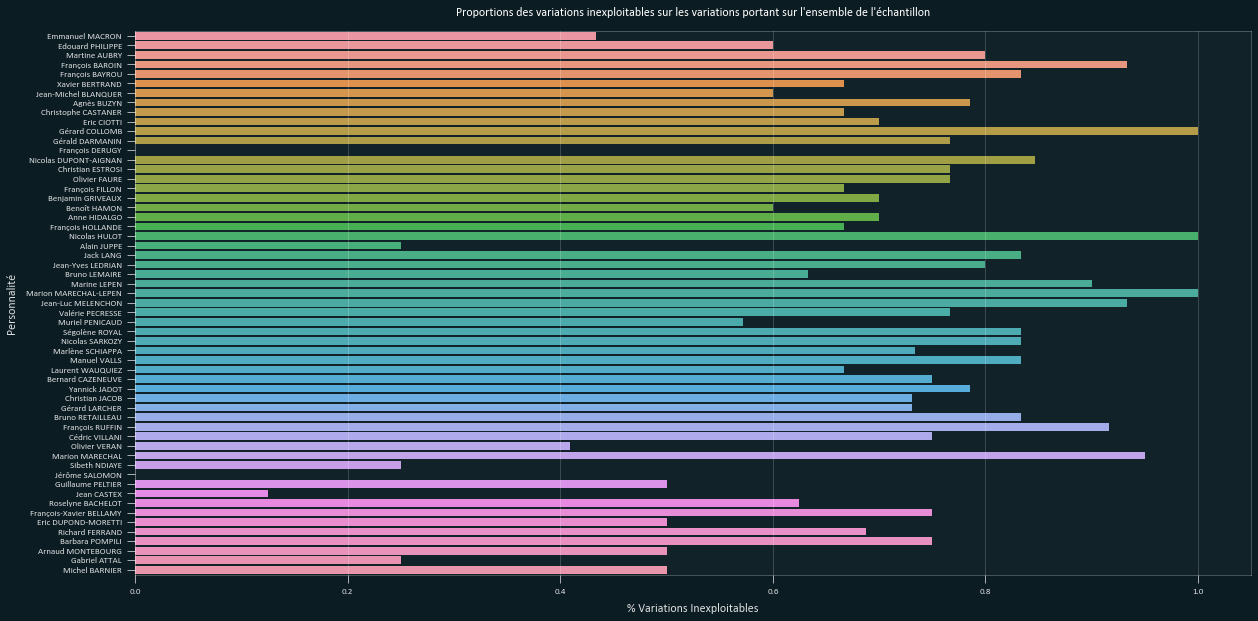

In [69]:
fig = plt.figure(figsize=(20,10))
ax=sns.barplot(x='Inexploitable',y='Nom',data=df_inex_ens,ci=None
#  ,estimator=lambda x: len(x) / len(df_inex[df_inex.Categorie=='ENSEMBLE']) * 100
)
ax.set(title="Proportions des variations inexploitables sur les variations portant sur l'ensemble de l'échantillon")
ax.set(xlabel="% Variations Inexploitables")
ax.set(ylabel="Personnalité ")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png',dpi=200)

In [70]:
print(df_inex_ens['Inexploitable'].value_counts()/len(groupe))
print(df_inex_ens['Inexploitable'].value_counts())
# data_f['Inexploitable Défavorable'].value_counts()

True     0.728333
False    0.271667
Name: Inexploitable, dtype: float64
True     874
False    326
Name: Inexploitable, dtype: int64


## Inexploitable sur toutes les variations

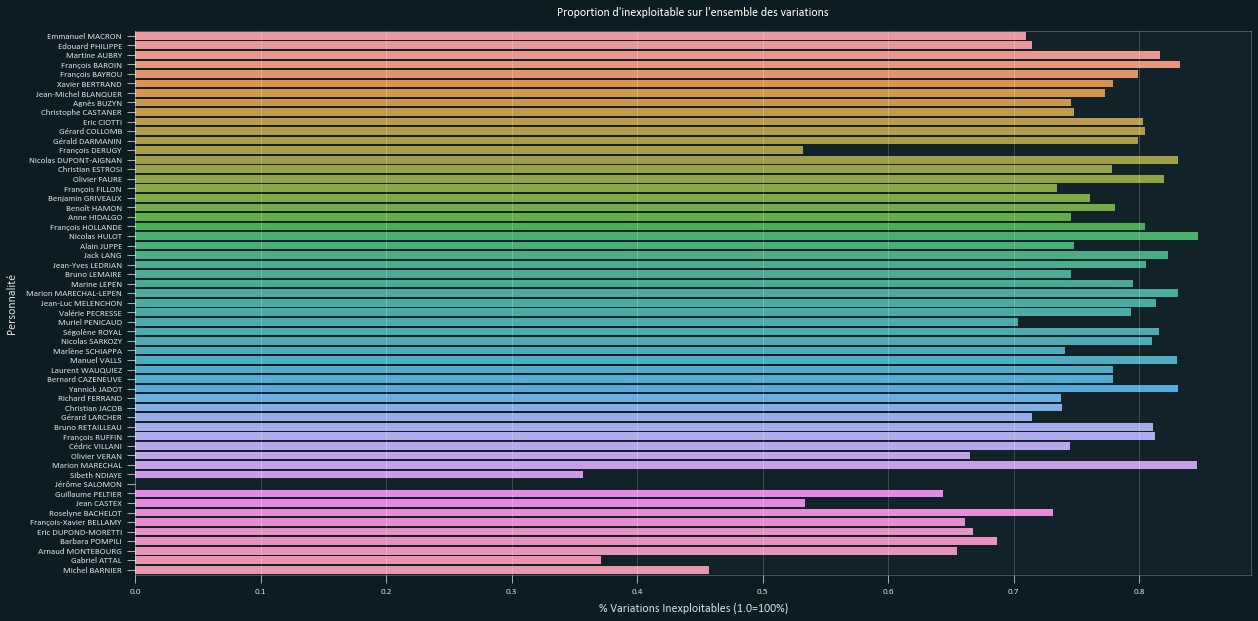

In [71]:
fig = plt.figure(figsize=(20,10))
ax=sns.barplot(x='Inexploitable',y='Nom',data=df_inex,ci=None\
#  ,estimator=lambda x: len(x) / len(df_inex[df_inex.Categorie=='ENSEMBLE']) * 100
)
ax.set(xlabel="% Variations Inexploitables (1.0=100%)")
ax.set(title="Proportion d'inexploitable sur l'ensemble des variations")
ax.set(ylabel="Personnalité ")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png',dpi=200)

In [72]:
print(df_inex['Inexploitable'].value_counts()/len(df_inex))
print(df_inex['Inexploitable'].value_counts())

True     0.766931
False    0.233069
Name: Inexploitable, dtype: float64
True     64367
False    19561
Name: Inexploitable, dtype: int64


## Taille échantillons groupes de gauche

In [73]:
data_f[data_f.Categorie=='Proximitépolitique'].Groupe.value_counts()

STFIPdGPC                  600
PS                         600
EELV                       600
LREM                       600
MoDem                      600
UDI                        600
LR                         600
DLF                        600
RN                         600
Aucunparti                 600
STGauche(FIPdGPCPSEELV)    600
STCentre(ModemLREM)        600
STDroite(LRUDI)            600
Name: Groupe, dtype: int64

In [74]:
filtre_soutien_gauche= (data_f.Groupe == 'PS') | (data_f.Groupe == 'EELV') | (data_f.Groupe == 'STFIPdGPC') # | (data_f.Groupe == 'STGauche(FIPdGPCPSEELV)') 
filtre_soutien_gauche_full= (data_f.Groupe == 'PS') | (data_f.Groupe == 'EELV') | (data_f.Groupe == 'STFIPdGPC')  | (data_f.Groupe == 'STGauche(FIPdGPCPSEELV)') 
taille_gauche_full=data_f[filtre_soutien_gauche_full][['Base','Date','Groupe']]
# test_df=taille_gauche_full=data_f[filtre_soutien_gauche_full][['Base','Date','Groupe']].pivot_table(values='Base',index=['Date'],columns=['Groupe'])
taille_gauche_detail=data_f[filtre_soutien_gauche][['Base','Date','Groupe']].pivot_table(values='Base',index=['Date'],columns=['Groupe'])
taille_gauche_detail.rename(columns={'STFIPdGPC':'FI-PdG-PC'}, inplace=True)
taille_gauche_detail=taille_gauche_detail[['FI-PdG-PC','PS','EELV']]
taille_gauche_full.replace('STFIPdGPC','FI-PdG-PC',inplace=True)
taille_gauche_full.replace('STGauche(FIPdGPCPSEELV)','Soutien Gauche (Total)',inplace=True)

In [75]:
macron_ens.head()

,index,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
0,0,Emmanuel MACRON,ENSEMBLE,ENSEMBLE,971.0,3.2,16.4,19.6,26.2,49.8,76.0,4.4,-6.4,5.7,2018-12-08,False,False,2.496908,2.686327
1,0,Emmanuel MACRON,ENSEMBLE,ENSEMBLE,1009.0,6.0,30.1,36.1,27.8,31.1,58.9,5.0,5.3,-5.1,2019-09-14,False,False,2.963565,3.035911
2,0,Emmanuel MACRON,ENSEMBLE,ENSEMBLE,1008.0,6.5,25.9,32.4,31.2,31.1,62.3,5.3,-3.7,3.4,2019-10-12,False,True,2.889160,2.991855
3,0,Emmanuel MACRON,ENSEMBLE,ENSEMBLE,1001.0,6.0,22.6,28.6,27.9,39.2,67.1,4.4,-4.4,3.8,2019-12-14,False,False,2.799440,2.910705
4,0,Emmanuel MACRON,ENSEMBLE,ENSEMBLE,1000.0,6.8,37.4,44.2,27.4,23.3,50.7,5.1,14.2,-12.3,2020-03-20,False,False,3.078111,3.098728


### Plot stack

(0.0, 350.0)

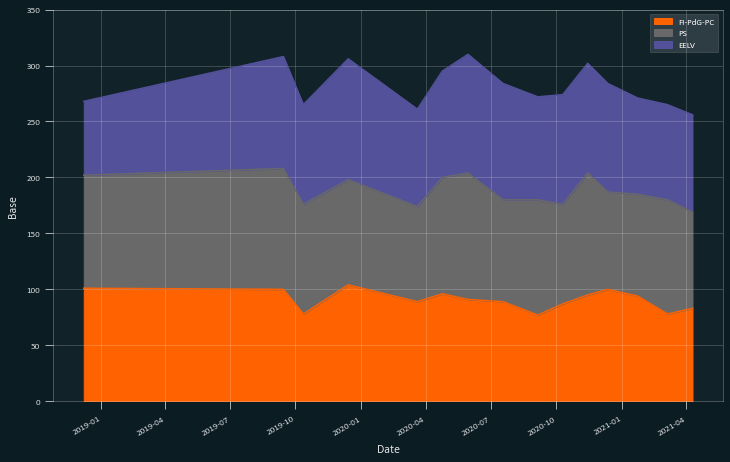

In [76]:

# fig = plt.figure(figsize=(12,8))
# ax=sns.lineplot(data=taille_gauche_detail,x='Date',y='Base',hue='Groupe')
# ax=sns.lineplot(data=taille_echantillon_gauche,x='Date',y='Base')

ax=taille_gauche_detail.plot.area(figsize=(12,8))
macron_ens=data_f[(data_f.Nom=='Emmanuel MACRON') & (data_f.Categorie=='ENSEMBLE')].reset_index()
sns.lineplot(data=macron_ens,x='Date',y='Base')
taille_gauche_detail
ax.set_ylim(0,350)

### Plot line

In [77]:
taille_gauche_full["Erreur"]=error_p(taille_gauche_full.Base/1000,1000)*1000
taille_gauche_full=taille_gauche_full.reset_index()

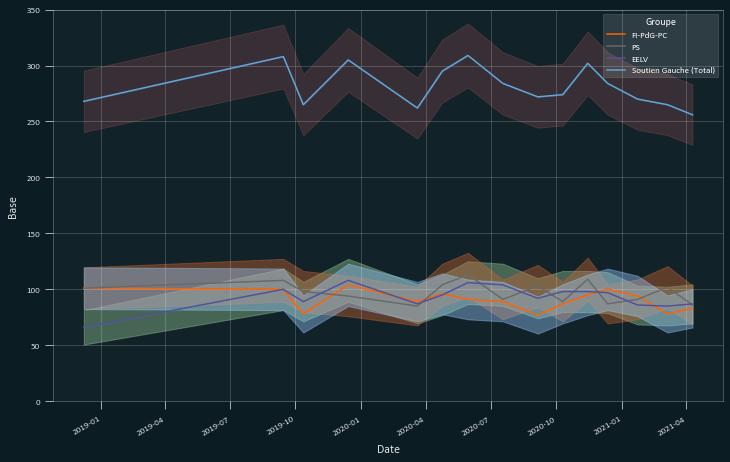

In [78]:
# years = mdates.YearLocator()   # every year
# months = mdates.MonthLocator()  # every month
# years_fmt = mdates.DateFormatter('%m-%Y')

fig = plt.figure(figsize=(12,8))
# ax=sns.lineplot(data=taille_gauche_detail,x='Date',y='Base',hue='Groupe')
ax=sns.lineplot(data=taille_gauche_full,x='Date',y='Base',hue='Groupe',err_style='band')
ax.set_ylim(0,350)

# # format the ticks
# ax.xaxis.set_major_locator(months)
# ax.xaxis.set_major_formatter(years_fmt)
# # ax.xaxis.set_minor_locator(months)

# # round to nearest years.
# datemin = np.datetime64(taille_gauche_full.Date.min())
# datemax = np.datetime64(taille_gauche_full.Date.max())
# ax.set_xlim(datemin, datemax)
# ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

# Organise date on ticks automatically
fig.autofmt_xdate()

total_gauche=taille_gauche_full[taille_gauche_full.Groupe=="Soutien Gauche (Total)"]
EELV=taille_gauche_full[taille_gauche_full.Groupe=="EELV"]
PS=taille_gauche_full[taille_gauche_full.Groupe=="PS"]
FI=taille_gauche_full[taille_gauche_full.Groupe=="FI-PdG-PC"]

plt.fill_between(total_gauche.Date, total_gauche.Base-total_gauche.Erreur, total_gauche.Base+total_gauche.Erreur,color='#cc6666', alpha=.2)
plt.fill_between(EELV.Date, EELV.Base-EELV.Erreur, EELV.Base+EELV.Erreur,color='#99cc99', alpha=.4)
plt.fill_between(PS.Date, PS.Base-PS.Erreur, PS.Base+PS.Erreur,color='#cc6633', alpha=.4)
plt.fill_between(FI.Date, FI.Base-FI.Erreur, FI.Base+FI.Erreur,color='#99ccff', alpha=.4)


# Variations personnalité

In [79]:
print(data_f.Categorie.value_counts())
data_f[data_f.Categorie=='Proximitépolitique'].Groupe.value_counts()

Proximitépolitique                   7800
Age                                  5400
PCSdel'individu                      4799
PCSdelapersonnederéférencedufoyer    4513
VotePrésidentielle20171ertour        4200
Région                               3600
Catégoried'agglomération             3000
Revenumensuelnetdufoyer              2400
VotePrésidentielle20172ndtour        2400
Diplômeleplusélevé                   1692
Sexe                                 1200
ENSEMBLE                              600
Agriculteurexploitant                 252
Niveaud'études                        108
Name: Categorie, dtype: int64


STFIPdGPC                  600
PS                         600
EELV                       600
LREM                       600
MoDem                      600
UDI                        600
LR                         600
DLF                        600
RN                         600
Aucunparti                 600
STGauche(FIPdGPCPSEELV)    600
STCentre(ModemLREM)        600
STDroite(LRUDI)            600
Name: Groupe, dtype: int64

In [80]:
nom='Jean CASTEX'
data_pers=data_f[(data_f.Nom==nom) & (data_f.Groupe=='ENSEMBLE')].reset_index()
data_pers['Erreur favorable']=error_p(data_pers['ST Favorable']/100,data_pers.Base)*100
data_pers['Erreur défavorable']=error_p(data_pers['ST Défavorable']/100,data_pers.Base)*100
data_pers

,index,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,...,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable,Erreur favorable,Erreur défavorable
0,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,4.8,27.9,32.7,15.8,11.5,...,39.9,0.0,0.0,2020-07-18,False,False,2.907619,2.761243,2.907619,2.761243
1,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,4.0,32.9,37.0,23.0,18.0,...,22.0,4.2,13.7,2020-09-05,False,False,2.992452,3.048414,2.992452,3.048414
2,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,3.4,31.6,35.0,30.4,18.2,...,16.4,-2.0,7.6,2020-10-10,True,False,2.956288,3.097817,2.956288,3.097817
3,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,2.9,28.5,31.4,33.4,26.7,...,8.5,-3.6,11.4,2020-11-14,False,False,2.876623,3.035147,2.876623,3.035147
4,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,3.1,32.9,36.0,29.7,27.3,...,6.9,4.6,-3.0,2020-12-12,False,True,2.975071,3.068511,2.975071,3.068511
5,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,3.4,28.3,31.7,34.3,27.0,...,7.0,-4.3,4.3,2021-01-23,False,False,2.884005,3.018852,2.884005,3.018852
6,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,4.6,31.6,36.3,32.4,23.5,...,7.8,4.6,-5.4,2021-03-06,False,False,2.980431,3.077381,2.980431,3.077381
7,70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1002.0,2.9,28.5,31.4,32.4,29.8,...,6.4,-4.9,6.3,2021-04-10,False,False,2.873751,3.002364,2.873751,3.002364


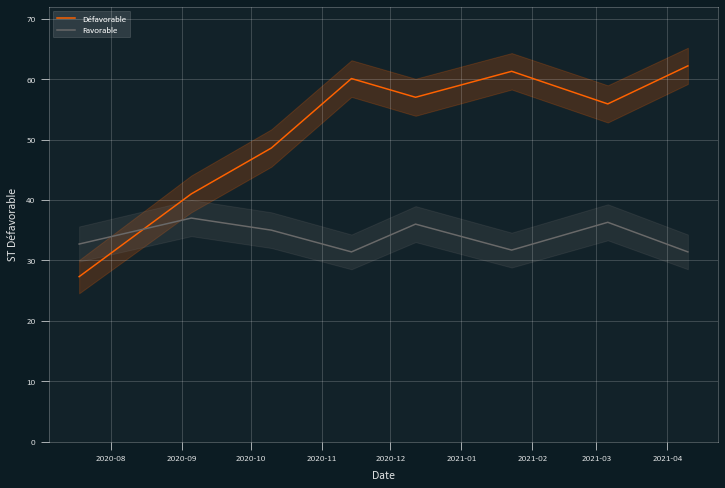

In [81]:


fig = plt.figure(figsize=(12,8))
# ax=sns.lineplot(data=taille_gauche_detail,x='Date',y='Base',hue='Groupe')

ax=sns.lineplot(data=data_pers,x='Date',y='ST Défavorable',label='Défavorable')
current_color=ax.get_lines()[0].get_color()
plt.fill_between(data_pers.Date, data_pers['ST Défavorable']-data_pers['Erreur défavorable'], data_pers['ST Défavorable']+data_pers['Erreur défavorable'],color=current_color, alpha=.2)

sns.lineplot(data=data_pers,x='Date',y='ST Favorable',label='Favorable')
current_color=ax.get_lines()[1].get_color()
plt.fill_between(data_pers.Date, data_pers['ST Favorable']-data_pers['Erreur favorable'], data_pers['ST Favorable']+data_pers['Erreur favorable'],color=current_color, alpha=.2)

# Organise date on ticks automatically
# fig.autofmt_xdate()
ax.set_ylim(0,int(np.max([data_pers['ST Favorable'].max(),data_pers['ST Défavorable'].max()]))+10)
plt.legend(loc='upper left')

# Analyse du dernier rapport

In [82]:
all_dates=np.sort(data_f.Date.unique())
most_recent=all_dates[-1]
scd_most_recent=all_dates[-2]

In [83]:
last_data=data_f[data_f.Date==data_f.Date.max()]
last_inex=pd.DataFrame()
last_inex['Résultats']=pd.concat([last_data['ST Favorable'],last_data['ST Défavorable']])
last_inex['Categorie']=pd.concat([last_data['Categorie'],last_data['Categorie']])
last_inex['Groupe']=pd.concat([last_data['Groupe'],last_data['Groupe']])
last_inex['Inexploitable']=pd.concat([last_data['Inexploitable Favorable'],last_data['Inexploitable Défavorable']])
last_inex['Nom']=pd.concat([last_data['Nom'],last_data['Nom']])
last_inex

,Résultats,Categorie,Groupe,Inexploitable,Nom
0,37.2,ENSEMBLE,ENSEMBLE,False,Emmanuel MACRON
1,37.3,Sexe,Homme,False,Emmanuel MACRON
2,37.0,Sexe,Femme,True,Emmanuel MACRON
3,45.8,Age,18à24ans,True,Emmanuel MACRON
4,32.7,Age,25à34ans,True,Emmanuel MACRON
...,...,...,...,...,...
2935,49.6,VotePrésidentielle20171ertour,STNonexpr.,False,Laurent WAUQUIEZ
2936,62.5,VotePrésidentielle20172ndtour,EmmanuelMacron,True,Laurent WAUQUIEZ
2937,55.2,VotePrésidentielle20172ndtour,MarineLePen,True,Laurent WAUQUIEZ
2938,60.0,VotePrésidentielle20172ndtour,STExpr.,True,Laurent WAUQUIEZ


## Inexploitables global

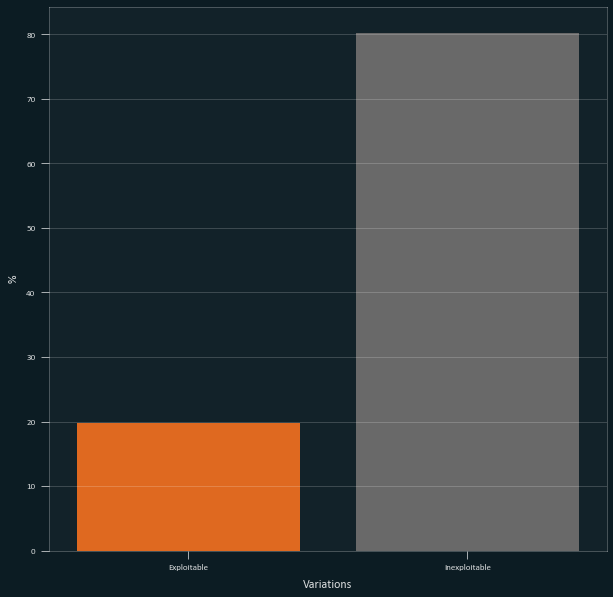

In [84]:
fig = plt.figure(figsize=(10,10))
ax=sns.barplot(x='Inexploitable', y='Inexploitable', data=last_inex, estimator=lambda x: len(x) / len(last_inex) * 100)
ax.set(ylabel="%")
ax.set(xlabel="Variations")
ax.set(xticklabels=['Exploitable', 'Inexploitable'])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png')

In [85]:
print(last_inex.Inexploitable.value_counts())
last_inex.Inexploitable.value_counts()/len(last_inex)

True     4718
False    1162
Name: Inexploitable, dtype: int64


True     0.802381
False    0.197619
Name: Inexploitable, dtype: float64

## Inexploitable par personnalité

### Inexploitable sur tout le jeu de données

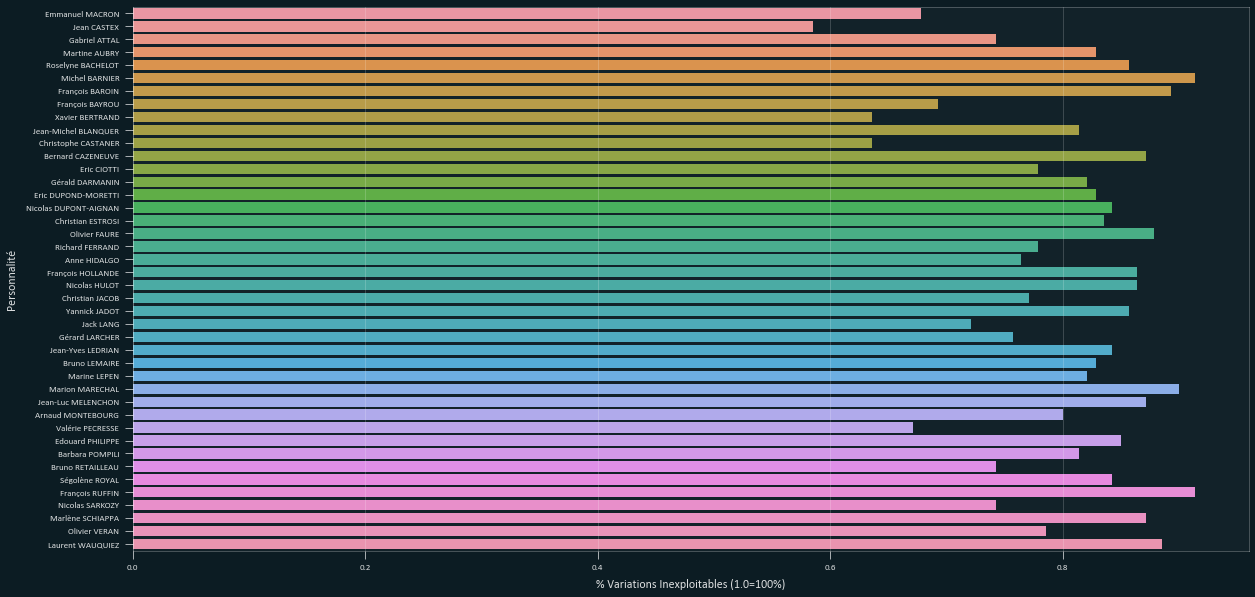

In [86]:
fig = plt.figure(figsize=(20,10))
ax=sns.barplot(x='Inexploitable',y='Nom',data=last_inex,ci=None
#  ,estimator=lambda x: len(x) / len(df_inex[df_inex.Categorie=='ENSEMBLE']) * 100
)
ax.set(xlabel="% Variations Inexploitables (1.0=100%)")
ax.set(ylabel="Personnalité ")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png')

In [87]:
print(last_inex['Inexploitable'].value_counts()/len(last_inex))
print(last_inex['Inexploitable'].value_counts())

True     0.802381
False    0.197619
Name: Inexploitable, dtype: float64
True     4718
False    1162
Name: Inexploitable, dtype: int64


### Inexploitable sur le groupe ENSEMBLE

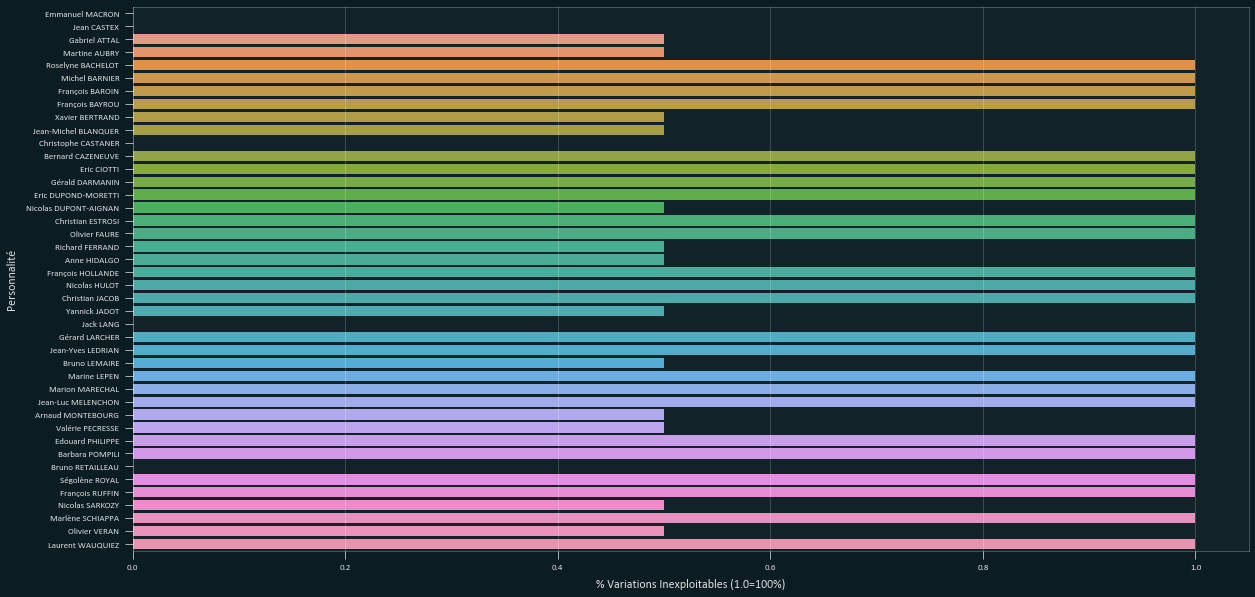

In [88]:
last_inex_ens=last_inex[last_inex.Categorie=='ENSEMBLE']
fig = plt.figure(figsize=(20,10))
ax=sns.barplot(x='Inexploitable',y='Nom',data=last_inex_ens,ci=None
#  ,estimator=lambda x: len(x) / len(df_inex[df_inex.Categorie=='ENSEMBLE']) * 100
)
ax.set(xlabel="% Variations Inexploitables (1.0=100%)")
ax.set(ylabel="Personnalité ")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png')

In [89]:
print(last_inex_ens['Inexploitable'].value_counts()/len(last_inex_ens))
print(last_inex_ens['Inexploitable'].value_counts())

True     0.72619
False    0.27381
Name: Inexploitable, dtype: float64
True     61
False    23
Name: Inexploitable, dtype: int64


In [90]:
nom='SCHIA'
categorie='Proximitépolitique'
last_inex[(last_inex.Nom.str.contains(nom))&(last_inex.Inexploitable==False)]

,Résultats,Categorie,Groupe,Inexploitable,Nom
2741,28.6,Age,ST60ansetplus,False,Marlène SCHIAPPA
2750,4.6,PCSdel'individu,Agriculteurexploitant,False,Marlène SCHIAPPA
2760,16.0,Région,Nord-Est,False,Marlène SCHIAPPA
2771,15.2,Revenumensuelnetdufoyer,De2.000-3.000€,False,Marlène SCHIAPPA
2779,64.4,Proximitépolitique,LREM,False,Marlène SCHIAPPA
2787,58.4,Proximitépolitique,STCentre(ModemLREM),False,Marlène SCHIAPPA
2740,59.1,Age,ST35à59ans,False,Marlène SCHIAPPA
2742,82.0,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,False,Marlène SCHIAPPA
2753,60.1,PCSdel'individu,Professionintermédiaire,False,Marlène SCHIAPPA
2755,52.0,PCSdel'individu,Ouvrier,False,Marlène SCHIAPPA


In [91]:
last_inex.Categorie.unique()

array(['ENSEMBLE', 'Sexe', 'Age', 'PCSdelapersonnederéférencedufoyer',
       "PCSdel'individu", 'Région', "Catégoried'agglomération",
       'Revenumensuelnetdufoyer', 'Diplômeleplusélevé',
       'Proximitépolitique', 'VotePrésidentielle20171ertour',
       'VotePrésidentielle20172ndtour'], dtype=object)

## Variation d'une personnalité sur les deux derniers jeux de données

In [92]:
nom="Emmanuel MACRON"
short_d=data_f[(data_f.Nom==nom) & ((data_f.Date==most_recent) | (data_f.Date==scd_most_recent)) & (data_f.Groupe=='Rural')].sort_values(by='Date',ascending=True,ignore_index=True)
print('Favorable')
print((margin_p(short_d['ST Favorable']/100,short_d.Base)*100).T)
print('Défavorable')
print((margin_p(short_d['ST Défavorable']/100,short_d.Base)*100).T)
short_d

Favorable
[[28.91821015 41.28178985]
 [24.25338923 36.14661077]]
Défavorable
[[50.38414749 63.21585251]
 [56.74669708 69.25330292]]


,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
0,Emmanuel MACRON,Catégoried'agglomération,Rural,229.0,4.8,30.3,35.1,34.0,22.8,56.8,8.1,0.9,-3.3,2021-03-06,True,True,6.181790,6.415853
1,Emmanuel MACRON,Catégoried'agglomération,Rural,229.0,4.8,25.4,30.2,30.2,32.8,63.0,6.7,-4.8,6.2,2021-04-10,True,True,5.946611,6.253303


In [93]:
data_f[(data_f.Nom==nom) & (data_f.Date==most_recent) & (data_f['Inexploitable Favorable']==False)]

,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
0,Emmanuel MACRON,ENSEMBLE,ENSEMBLE,1002.0,4.2,32.9,37.2,27.6,30.0,57.6,5.2,-3.8,5.0,2021-04-10,False,False,2.992771,3.059964
1,Emmanuel MACRON,Sexe,Homme,477.0,5.2,32.1,37.3,29.7,28.3,58.0,4.7,-5.5,3.4,2021-04-10,False,True,4.339953,4.429304
6,Emmanuel MACRON,Age,45à59ans,330.0,3.5,27.7,31.2,30.4,34.1,64.5,4.3,-8.4,9.1,2021-04-10,False,False,4.998856,5.162893
10,Emmanuel MACRON,Age,ST35à59ans,437.0,3.7,27.4,31.1,30.9,33.5,64.4,4.5,-8.8,10.3,2021-04-10,False,False,4.340154,4.489348
13,Emmanuel MACRON,PCSdelapersonnederéférencedufoyer,Professionindépendante,39.0,13.0,11.2,24.2,25.9,37.9,63.8,12.0,-22.8,18.8,2021-04-10,False,False,13.442067,15.083023
20,Emmanuel MACRON,PCSdel'individu,Agriculteurexploitant,10.0,12.0,19.1,31.0,39.1,24.6,63.7,5.3,-45.4,40.1,2021-04-10,False,False,28.665628,29.804312
30,Emmanuel MACRON,Région,Nord-Est,225.0,1.9,31.2,33.1,30.4,34.6,65.0,1.9,-10.3,13.1,2021-04-10,False,False,6.148821,6.232403
33,Emmanuel MACRON,Région,STProvince,817.0,3.6,33.4,37.0,28.0,29.6,57.7,5.3,-5.2,6.5,2021-04-10,False,False,3.310672,3.387686
37,Emmanuel MACRON,Catégoried'agglomération,Plusde100.000hab.,300.0,3.4,37.3,40.7,26.1,26.6,52.7,6.6,-8.2,7.0,2021-04-10,False,False,5.559299,5.649777
43,Emmanuel MACRON,Diplômeleplusélevé,InférieurauBAC,401.0,3.4,26.7,30.2,27.3,36.6,63.9,6.0,-6.8,8.3,2021-04-10,False,False,4.493814,4.700975


# Dernière variation observable

In [94]:


def find_last_var(df):
    last_var={}
    for nom in df.Nom.unique():
        last_var[nom]={'fav':None,'defav':None,'date_fav':None,'date_defav':None}
        df_var=df[(df.Nom==nom) & (df.Categorie=='ENSEMBLE')]
        df_var=df_var.sort_values(by='Date',ascending=False,ignore_index=True)
        l_base=df_var.iloc[0].Base
        l_fav=df_var.iloc[0]['ST Favorable']
        l_defav=df_var.iloc[0]['ST Défavorable']
        er_l_fav=error_p(l_fav/100,l_base)*100
        er_l_defav=error_p(l_defav/100,l_base)*100
        for i in range(1,len(df_var)):
            t=df_var.iloc[i]
            t_base=t.Base
            t_fav=t['ST Favorable']
            t_defav=t['ST Défavorable']
            er_t_fav=error_p(t_fav/100,t_base)*100
            er_t_defav=error_p(t_defav/100,t_base)*100
            # print(l_fav,er_l_fav,t_fav,er_t_fav)
            if l_fav+er_l_fav < t_fav-er_t_fav and last_var[nom]['fav']==None:
                last_var[nom]['fav']= t_fav-er_t_fav-(l_fav+er_l_fav)
                last_var[nom]['date_fav']= t.Date                
            elif l_fav-er_l_fav > t_fav+er_t_fav and last_var[nom]['fav']==None:
                last_var[nom]['fav']= l_fav+er_l_fav-(t_fav-er_t_fav)
                last_var[nom]['date_fav']= t.Date                
            if l_defav+er_l_defav < t_defav-er_t_defav and last_var[nom]['defav']==None:
                last_var[nom]['defav']= t_defav-er_t_defav-(l_defav+er_l_defav)
                last_var[nom]['date_defav']= t.Date                
            elif l_defav-er_l_defav > t_defav+er_t_defav and last_var[nom]['defav']==None:
                last_var[nom]['defav']= l_defav+er_l_defav-(t_defav-er_t_defav)
                last_var[nom]['date_defav']= t.Date                
    return last_var

In [95]:
nom='Emmanuel MACRON'
last_var=find_last_var(data_f)
last_var[nom] 

{'fav': 0.9291176904457643,
 'defav': 13.058692834304424,
 'date_fav': Timestamp('2020-03-20 00:00:00'),
 'date_defav': Timestamp('2020-03-20 00:00:00')}

In [96]:
def find_last_var_usable(df):
    cols=['Nom','VarFav','DateFav','VarDefav','DateDefav']
    last_var=pd.DataFrame(columns=cols)
    for nom in df.Nom.unique():   
        t_uple=[nom]
        c_df=df.loc[(df.Nom==nom) & (df['Inexploitable Favorable']==False) & (df['Evolution ST Favorable']!=0)].sort_values(by=['Date'],ascending=False)
        if not c_df.empty:
            dernier_val=c_df.iloc[0]
            t_uple.append(dernier_val['Evolution ST Favorable'])
            t_uple.append(dernier_val['Date'])
        else:
            t_uple.extend([np.nan,np.nan])
            
        c_df=df.loc[(df.Nom==nom) & (df['Inexploitable Défavorable']==False) & (df['Evolution ST Défavorable']!=0)].sort_values(by=['Date'],ascending=False)
        if not c_df.empty:
            dernier_val=c_df.iloc[0]
            t_uple.append(dernier_val['Evolution ST Défavorable'])
            t_uple.append(dernier_val['Date'])
        else:
            t_uple.extend([np.nan,np.nan])
        last_var=last_var.append(pd.Series(t_uple, index=cols),ignore_index=True)
    return last_var


In [97]:
find_last_var_usable(data_f[data_f.Categorie=='ENSEMBLE'])

,Nom,VarFav,DateFav,VarDefav,DateDefav
0,Emmanuel MACRON,-3.8,2021-04-10,5.0,2021-04-10 00:00:00
1,Edouard PHILIPPE,-5.5,2021-01-23,-5.0,2021-03-06 00:00:00
2,Martine AUBRY,-3.5,2020-05-30,4.2,2021-04-10 00:00:00
3,François BAROIN,3.8,2019-10-12,-4.3,2020-11-14 00:00:00
4,François BAYROU,-3.8,2019-12-14,-3.7,2020-12-12 00:00:00
5,Xavier BERTRAND,5.9,2020-03-20,5.0,2021-04-10 00:00:00
6,Jean-Michel BLANQUER,-3.6,2021-01-23,3.7,2021-04-10 00:00:00
7,Agnès BUZYN,-4.8,2020-04-24,8.0,2020-03-20 00:00:00
8,Christophe CASTANER,-4.3,2021-04-10,4.6,2021-04-10 00:00:00
9,Eric CIOTTI,3.5,2020-03-20,-4.7,2021-03-06 00:00:00


## Verification pas de données bizarre

In [98]:
data_f[data_f.Base==0]



,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable


In [99]:
favUnmatch=data_f[np.abs(data_f['Très favorable']+data_f['Plutôt favorable']-data_f['ST Favorable'])>0.11]
favUnmatch

,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable


In [100]:
defavUnmatch=data_f[np.abs(data_f['Très défavorable']+data_f['Plutôt défavorable']-data_f['ST Défavorable'])>0.11]
defavUnmatch

,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable


In [101]:
unmatch=data_f[np.abs(data_f['ST Favorable']+data_f['ST Défavorable']+data_f['Nsp'])<99.89]
unmatch



,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable


In [102]:
dates=np.sort(data_f.Date.unique())
last_date=dates[len(dates)-1]
prev_date=dates[len(dates)-2]
l_data=data_f[data_f.Date==last_date]
p_data=data_f[data_f.Date==prev_date]
l_noms=np.sort(l_data.Nom.unique())
p_noms=np.sort(p_data.Nom.unique())


for nom in l_noms:
    if nom in p_noms:
        lastd=l_data[l_data.Nom==nom]
        prevd=p_data[p_data.Nom==nom]
        lastd['Prev_calc']=lastd['ST Favorable']-lastd['Evolution ST Favorable']
        # check_cond=(l_data.Nom==p_data.Nom) & (l_data.Categorie==p_data.Categorie) & (l_data.Groupe==p_data.Groupe)
        lastd['Prev']= prevd['ST Favorable']
        weird=lastd[np.abs(lastd['Prev'] - lastd['Prev_calc'])> 0.11]
        if len(weird)>0:
            weird
        else:
            print('{} is clear'.format(nom))


Anne HIDALGO is clear
Arnaud MONTEBOURG is clear
Barbara POMPILI is clear
Bernard CAZENEUVE is clear
Bruno LEMAIRE is clear
Bruno RETAILLEAU is clear
Christian ESTROSI is clear
Christian JACOB is clear
Christophe CASTANER is clear
Edouard PHILIPPE is clear
Emmanuel MACRON is clear
Eric CIOTTI is clear
Eric DUPOND-MORETTI is clear
François BAROIN is clear
François BAYROU is clear
François HOLLANDE is clear
François RUFFIN is clear
Gabriel ATTAL is clear
Gérald DARMANIN is clear
Gérard LARCHER is clear
Jack LANG is clear
Jean CASTEX is clear
Jean-Luc MELENCHON is clear
Jean-Michel BLANQUER is clear
Jean-Yves LEDRIAN is clear
Laurent WAUQUIEZ is clear
Marine LEPEN is clear
Marion MARECHAL is clear
Marlène SCHIAPPA is clear
Martine AUBRY is clear
Michel BARNIER is clear
Nicolas DUPONT-AIGNAN is clear
Nicolas HULOT is clear
Nicolas SARKOZY is clear
Olivier FAURE is clear
Olivier VERAN is clear
Richard FERRAND is clear
Roselyne BACHELOT is clear
Ségolène ROYAL is clear
Valérie PECRESSE is cl

C:\Users\Romain\AppData\Local\Temp/ipykernel_28012/3509467607.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lastd['Prev_calc']=lastd['ST Favorable']-lastd['Evolution ST Favorable']
C:\Users\Romain\AppData\Local\Temp/ipykernel_28012/3509467607.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lastd['Prev']= prevd['ST Favorable']


In [103]:
for i in weird.index:
    print(p_data.loc[i ])

In [104]:
last_data

,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
0,Emmanuel MACRON,ENSEMBLE,ENSEMBLE,1002.0,4.2,32.9,37.2,27.6,30.0,57.6,5.2,-3.8,5.0,2021-04-10,False,False,2.992771,3.059964
1,Emmanuel MACRON,Sexe,Homme,477.0,5.2,32.1,37.3,29.7,28.3,58.0,4.7,-5.5,3.4,2021-04-10,False,True,4.339953,4.429304
2,Emmanuel MACRON,Sexe,Femme,525.0,3.4,33.7,37.0,25.8,31.5,57.3,5.7,-2.2,6.4,2021-04-10,True,False,4.129976,4.231240
3,Emmanuel MACRON,Age,18à24ans,106.0,9.4,36.4,45.8,25.6,17.7,43.3,10.9,-1.2,0.5,2021-04-10,True,True,9.484960,9.432756
4,Emmanuel MACRON,Age,25à34ans,159.0,2.3,30.4,32.7,29.9,29.3,59.1,8.1,-7.4,10.1,2021-04-10,True,False,7.291870,7.642103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,Laurent WAUQUIEZ,VotePrésidentielle20171ertour,STNonexpr.,229.0,0.8,8.4,9.3,25.7,23.8,49.6,41.1,-4.6,8.8,2021-04-10,False,False,3.761694,6.475815
2936,Laurent WAUQUIEZ,VotePrésidentielle20172ndtour,EmmanuelMacron,418.0,1.9,18.6,20.5,32.0,30.4,62.5,17.1,6.8,-3.2,2021-04-10,False,True,3.870156,4.641128
2937,Laurent WAUQUIEZ,VotePrésidentielle20172ndtour,MarineLePen,215.0,4.0,19.8,23.8,35.6,19.6,55.2,21.0,-6.1,6.7,2021-04-10,True,True,5.692497,6.647302
2938,Laurent WAUQUIEZ,VotePrésidentielle20172ndtour,STExpr.,633.0,2.6,19.0,21.6,33.2,26.8,60.0,18.4,2.4,0.2,2021-04-10,True,True,3.205820,3.816452


# Variation des paramètres non critères pour les quotas

In [105]:
data_f.Categorie.unique()

array(['ENSEMBLE', 'Sexe', 'Age', 'Agriculteurexploitant',
       "PCSdel'individu", 'Région', "Catégoried'agglomération",
       'Revenumensuelnetdufoyer', "Niveaud'études", 'Proximitépolitique',
       'VotePrésidentielle20171ertour', 'VotePrésidentielle20172ndtour',
       'PCSdelapersonnederéférencedufoyer', 'Diplômeleplusélevé'],
      dtype=object)

In [106]:
data_f[data_f.Categorie=='Proximitépolitique'].Groupe.value_counts()

STFIPdGPC                  600
PS                         600
EELV                       600
LREM                       600
MoDem                      600
UDI                        600
LR                         600
DLF                        600
RN                         600
Aucunparti                 600
STGauche(FIPdGPCPSEELV)    600
STCentre(ModemLREM)        600
STDroite(LRUDI)            600
Name: Groupe, dtype: int64

<AxesSubplot:xlabel='Date', ylabel='Base'>

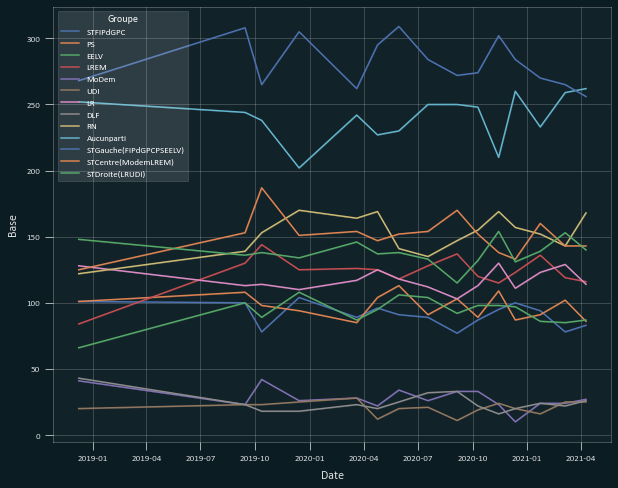

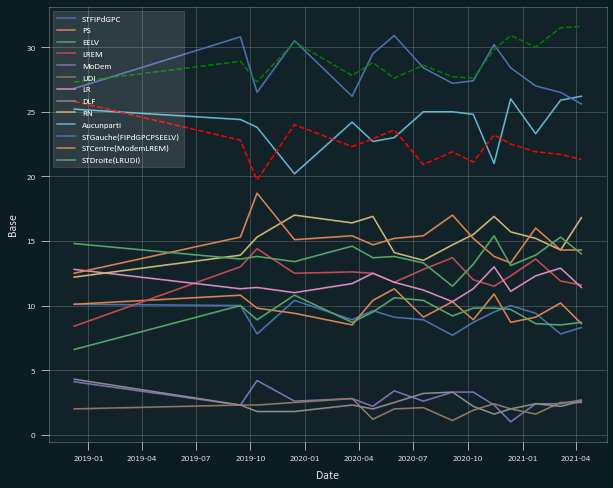

In [109]:
plt.figure(figsize=(10,8))
df_plot=data_f[data_f.Categorie=="Proximitépolitique"].reset_index()
# df_plot=df_plot[df_plot.Groupe.isin(['STFIPdGPC','PS',"EELV",'LREM','MoDem','UDI','LR','DLF','RN','Aucunparti'])]
sns.lineplot(x='Date',y=df_plot.Base,data=df_plot,hue='Groupe', palette="deep")
plt.figure(figsize=(10,8))
sns.lineplot(x='Date',y=df_plot.Base/10,data=df_plot,hue='Groupe', palette="deep")
sns.lineplot(x='Date',y='ST Favorable',data=data_f[(data_f.Categorie=='ENSEMBLE')
        & (data_f.Nom=='Jean-Luc MELENCHON')].reset_index(),color='red',linestyle='--')
sns.lineplot(x='Date',y='ST Favorable',data=data_f[(data_f.Categorie=='ENSEMBLE') & (data_f.Nom=='Marine LEPEN')].reset_index(),color='green',linestyle='--')

In [ ]:
data_f[data_f.Categorie=="PCSdel'individu"].Groupe.unique()

array(['Agriculteurexploitant', 'Professionindépendante',
       'Cadresupérieur', 'Professionintermédiaire', 'Employé', 'Ouvrier',
       'Retraité', 'Inactif'], dtype=object)

In [ ]:
data_f.Categorie.unique()

array(['ENSEMBLE', 'Sexe', 'Age', 'Agriculteurexploitant',
       "PCSdel'individu", 'Région', "Catégoried'agglomération",
       'Revenumensuelnetdufoyer', "Niveaud'études", 'Proximitépolitique',
       'VotePrésidentielle20171ertour', 'VotePrésidentielle20172ndtour',
       'PCSdelapersonnederéférencedufoyer', 'Diplômeleplusélevé'],
      dtype=object)